In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from scipy.signal import periodogram
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

2024-08-07 21:48:15.803743: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 21:48:15.803919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 21:48:15.990477: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Importing data

dataset - [Time Series starter dataset](https://www.kaggle.com/datasets/podsyp/time-series-starter-dataset/data)



In [2]:
df = pd.read_csv("/kaggle/input/time-series-starter-dataset/Month_Value_1.csv")
df['Period'] = pd.to_datetime(df['Period'], format='%d.%m.%Y')

df['Period'] = df.Period.dt.to_period('M')
df.set_index('Period', inplace=True)

df

,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
Period,,,,
2015-01,1.601007e+07,12729.0,1257.763541,30024676.0
2015-02,1.580759e+07,11636.0,1358.507000,30024676.0
2015-03,2.204715e+07,15922.0,1384.697024,30024676.0
2015-04,1.881458e+07,15227.0,1235.606705,30024676.0
2015-05,1.402148e+07,8620.0,1626.621765,30024676.0
...,...,...,...,...
2022-08,NaN,NaN,NaN,NaN
2022-09,NaN,NaN,NaN,NaN
2022-10,NaN,NaN,NaN,NaN


# Let's start from researching the database.

* check if there are any empty values, and decide what to do about them.
* find and inverstigate correlations

In [3]:
print(df.isna().sum())

# uncomment to see Nan rows
# df[-32:]

Revenue                                     32
Sales_quantity                              32
Average_cost                                32
The_average_annual_payroll_of_the_region    32
dtype: int64


# Forecast horizon
The dataset concludes at index 63, corresponding to the date 01.04.2020, indicating the starting point for our predictions. The forecast horizon spans 33 periods, implying that data is available for only 65% of the rows in the dataframe.

In [4]:
test = df[-32:]
train = df[:len(df)-32]

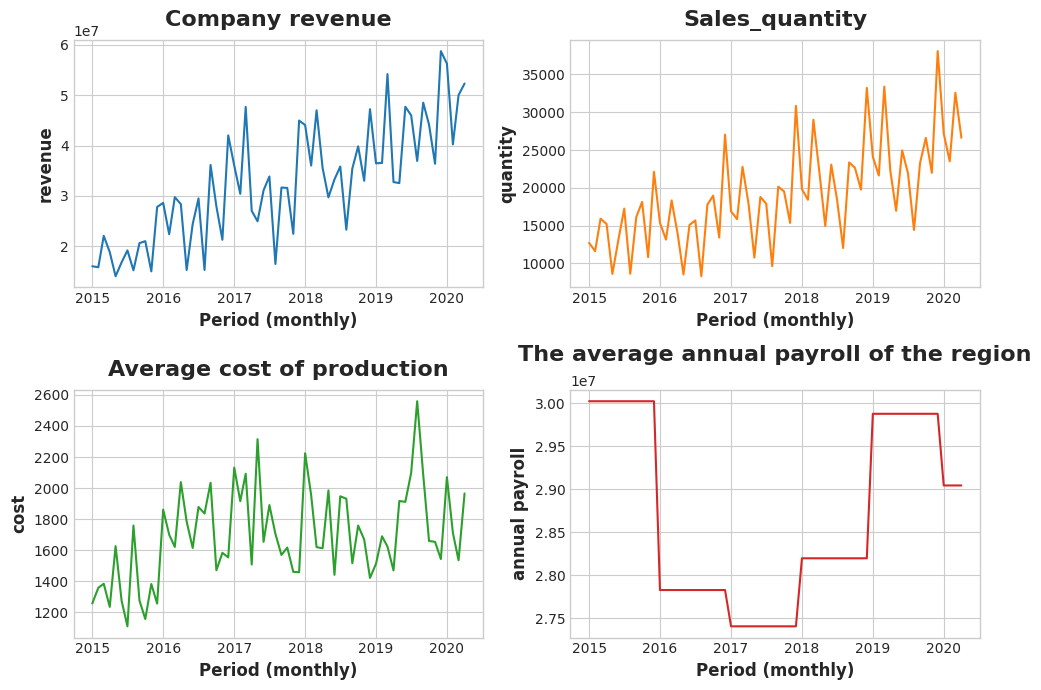

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7))

axs[0, 0].plot(train.index.to_timestamp(), train["Revenue"])
axs[0, 0].set_title("Company revenue")
axs[0, 0].set_xlabel("Period (monthly)")
axs[0, 0].set_ylabel("revenue")

axs[0, 1].plot(train.index.to_timestamp(), train["Sales_quantity"], 'tab:orange')
axs[0, 1].set_title("Sales_quantity")
axs[0, 1].set_xlabel("Period (monthly)")
axs[0, 1].set_ylabel("quantity")

axs[1, 0].plot(train.index.to_timestamp(), train["Average_cost"], 'tab:green')
axs[1, 0].set_title("Average cost of production")
axs[1, 0].set_xlabel("Period (monthly)")
axs[1, 0].set_ylabel("cost")

axs[1, 1].plot(train.index.to_timestamp(), train["The_average_annual_payroll_of_the_region"], 'tab:red')
axs[1, 1].set_title("The average annual payroll of the region")
axs[1, 1].set_xlabel("Period (monthly)")
axs[1, 1].set_ylabel("annual payroll")

plt.tight_layout()

plt.show()

# Detrending
In order to research deeply correlations we need to detrend those values

Let's start from looking at moving average for these plots

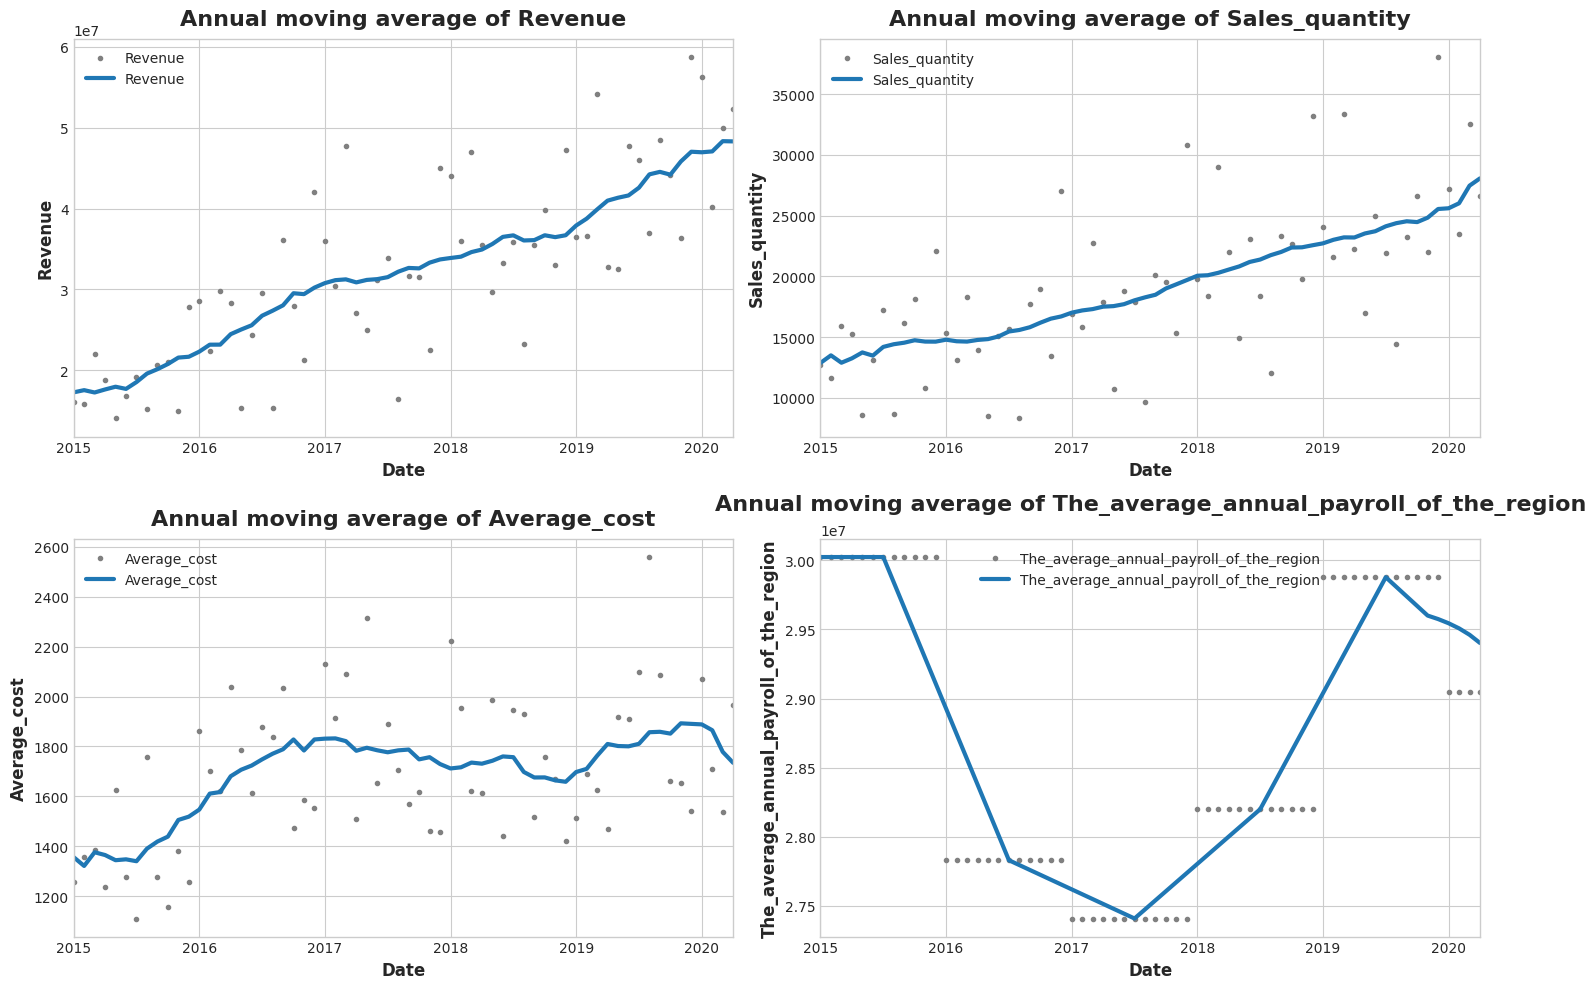

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

moving_averages = []

for i, column in enumerate(train.columns):
    moving_avg = train[column].rolling(window=12, center=True, min_periods=6).mean()
    
    moving_averages.append(moving_avg)
    
    ax = train[column].plot(ax=axes[i], style=".", color="0.5", title=column, legend=True)
    moving_avg.plot(ax=ax, linewidth=3, title=f"Annual moving average of {column}", legend=True)
    ax.set_xlabel('Date')
    ax.set_ylabel(column)

plt.tight_layout()
plt.show()

Based on those plots its visible that Revenue and Sales quantity have aproximately linear upwarding trends. Average cost is more complicated, because at the very last available period it starts going downwards rapidly which may cause some trouble predicting, despite that, let's apply moving average instead of regression for that specific column.

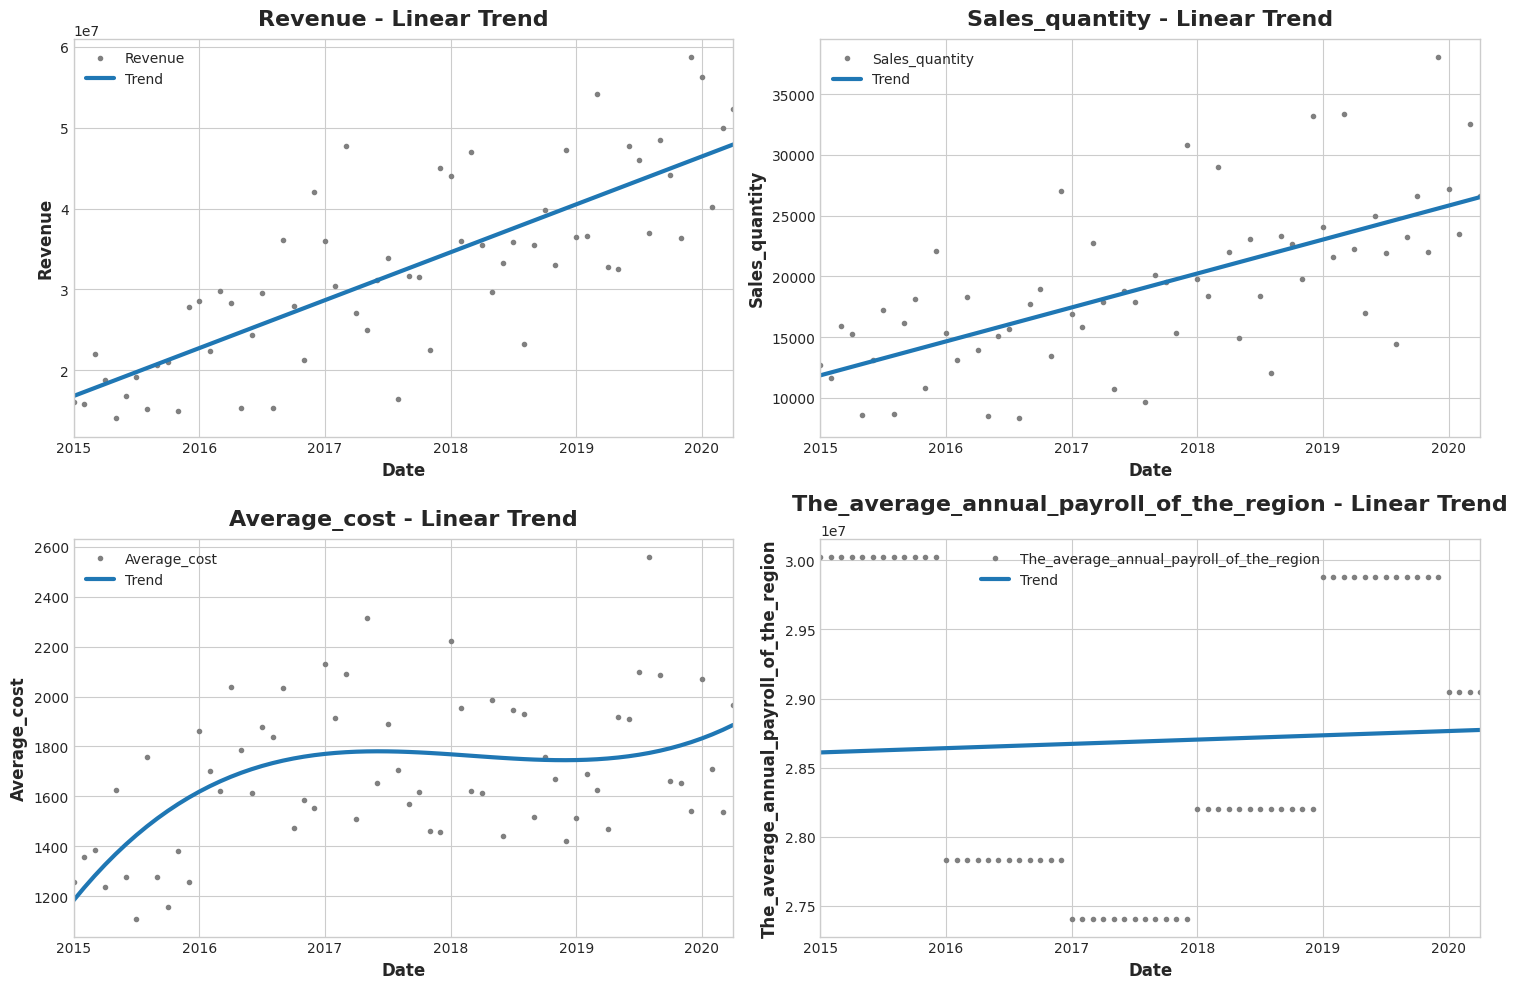

In [7]:
revenue = train[['Revenue']]
sales_quantity = train[['Sales_quantity']]
average_cost = train[['Average_cost']]
payroll = train[['The_average_annual_payroll_of_the_region']]

cols = [revenue, sales_quantity, average_cost, payroll]

# There are stored trends
trends = []

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(cols):
    dp = DeterministicProcess(
        index=col.index,
        constant=True,
        order=1,
        drop=True,
    )
    # Average_cost polynomial
    if i == 2:
        dp = DeterministicProcess(
        index=col.index,
        constant=True,
        order=3,
        drop=True,
    )
    X = dp.in_sample()
    y = col[col.columns[0]]
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    
    y_pred = pd.Series(model.predict(X), index=X.index)
    
    trends.append(model.predict(X))
    
    ax = col.plot(ax=axes[i], style=".", color="0.5", title=f"{col.columns[0]} - Linear Trend")
    y_pred.plot(ax=ax, linewidth=3, label="Trend", legend=True)
    ax.set_xlabel('Date')
    ax.set_ylabel(col.columns[0])

plt.tight_layout()
plt.show()

The annual payroll doesn't seem to have any significatrend, data looks like there could be potentially some crisis going on from 2017 to 2018, so we will get back to this later.

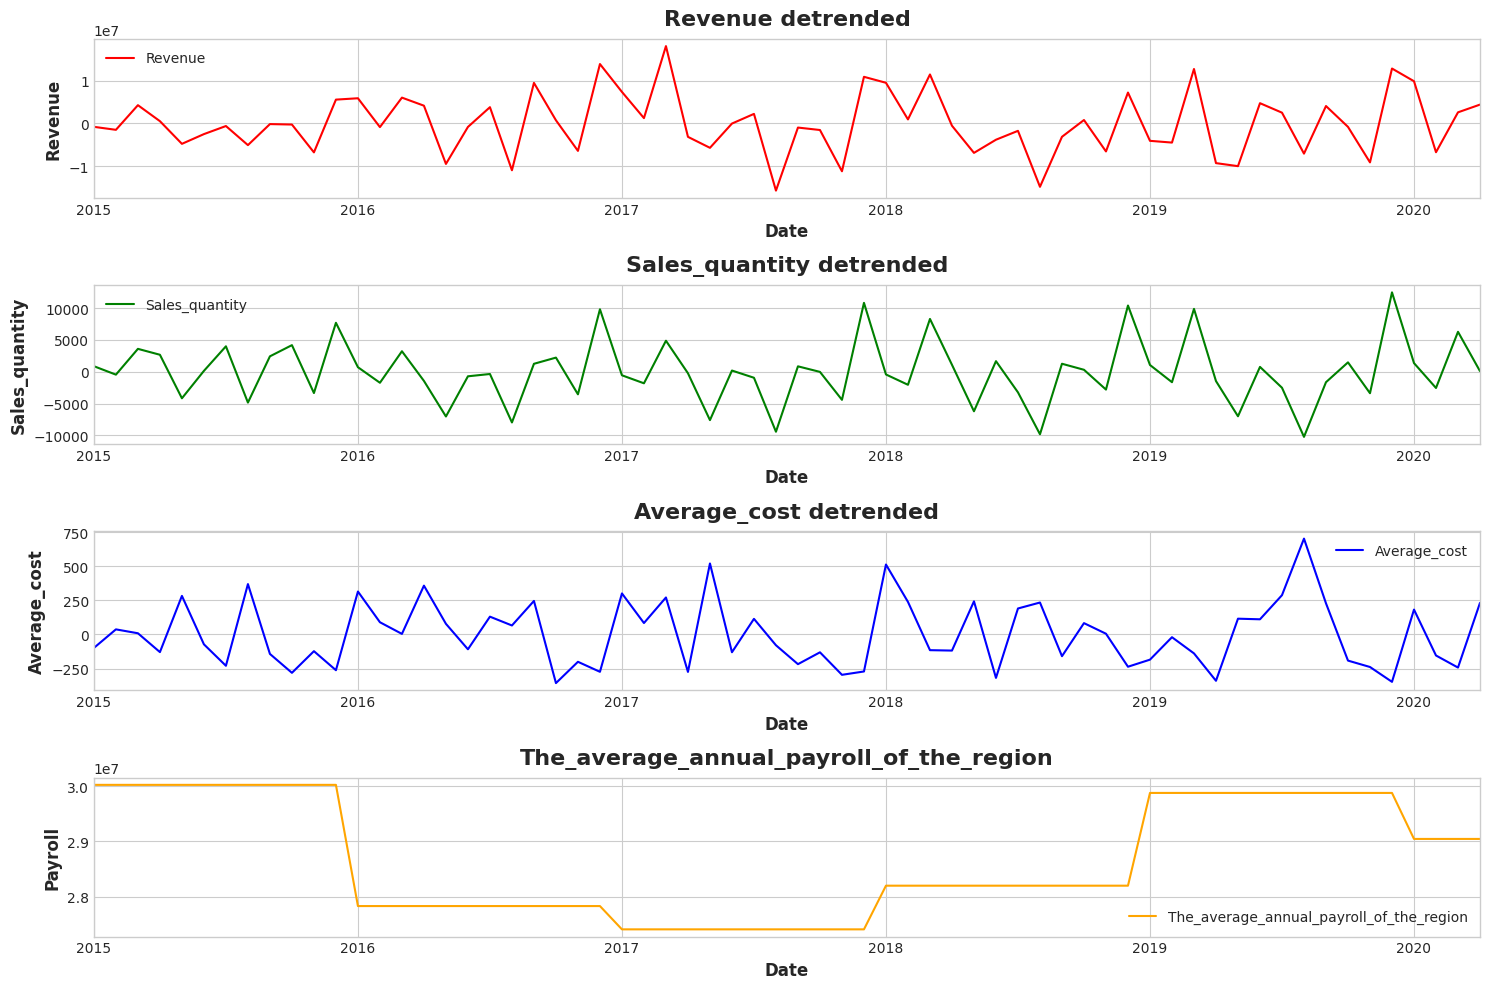

In [8]:
revenue_detrended = revenue["Revenue"] - trends[0]
sales_quantity_detrended = sales_quantity["Sales_quantity"] - trends[1]

# this time using moving average instead of linear regression
average_cost_detrended = average_cost["Average_cost"] - moving_averages[2]

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 10))
axes = axes.flatten()

ax = revenue_detrended.plot(ax=axes[0], color="red", title="Revenue detrended", legend=True)
ax.set_xlabel('Date')
ax.set_ylabel("Revenue")

ax = sales_quantity_detrended.plot(ax=axes[1], color="green", title="Sales_quantity detrended", legend=True)
ax.set_xlabel('Date')
ax.set_ylabel("Sales_quantity")

ax = average_cost_detrended.plot(ax=axes[2], color="blue", title="Average_cost detrended", legend=True)
ax.set_xlabel('Date')
ax.set_ylabel("Average_cost")

ax = payroll.plot(ax=axes[3], color="orange", title="The_average_annual_payroll_of_the_region", legend=True)
ax.set_xlabel('Date')
ax.set_ylabel("Payroll")
plt.tight_layout()
plt.show()


# Deseasoning 
Now after detrending, let's taka a look at those plots. There are some visible patterns - *seasonality / cycles*. Its time to handle these. Potentially, average values are higher around new year.

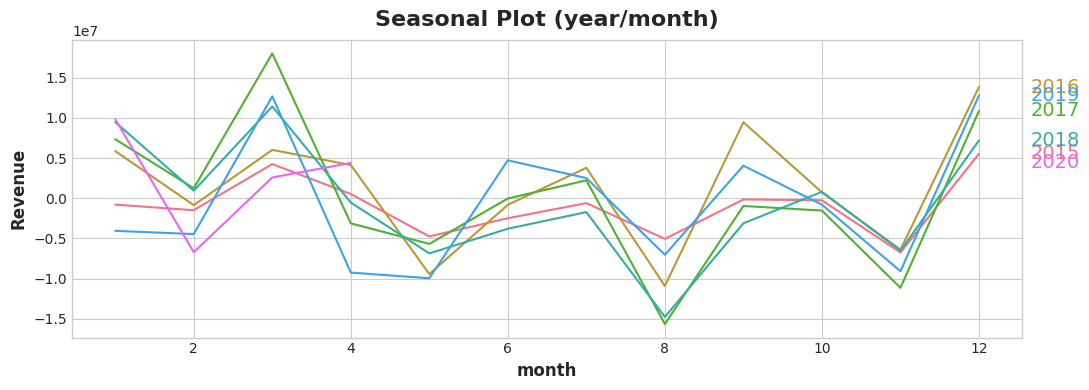

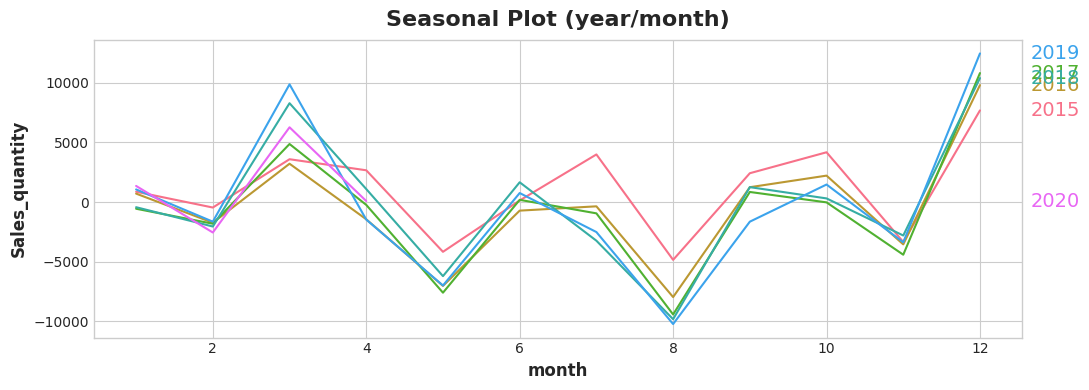

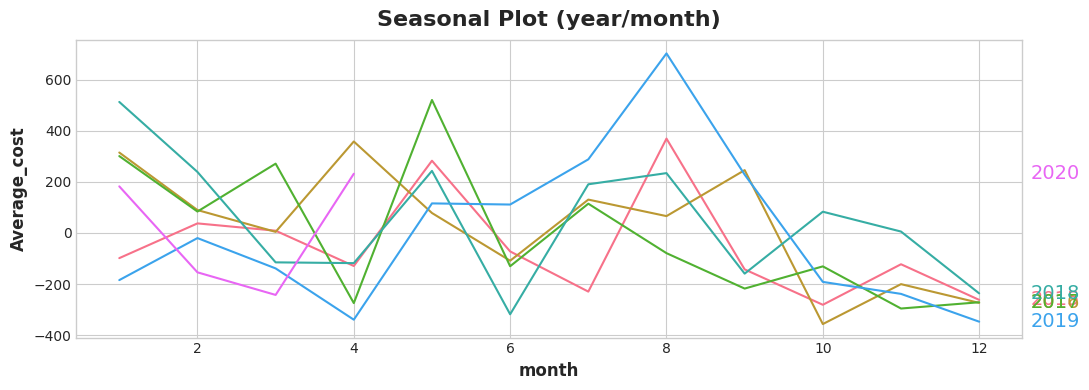

In [9]:

detrended_train = pd.DataFrame()
detrended_train["Revenue"] = revenue_detrended
detrended_train["Sales_quantity"] = sales_quantity_detrended
detrended_train["Average_cost"] = average_cost_detrended
detrended_train["The_average_annual_payroll_of_the_region"] = payroll

X = detrended_train.copy()
X["month"] = X.index.month
X["year"] = X.index.year
seasonal_plot(X, y='Revenue', period='year', freq='month');
seasonal_plot(X, y='Sales_quantity', period='year', freq='month');
seasonal_plot(X, y='Average_cost', period='year', freq='month');

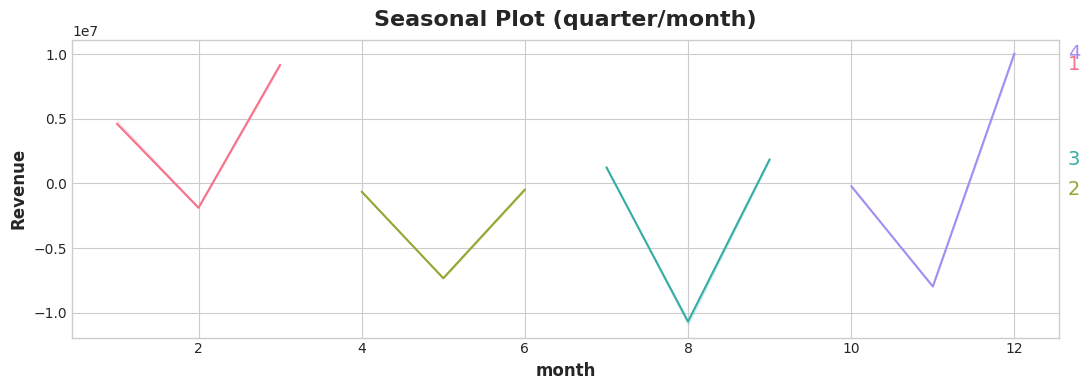

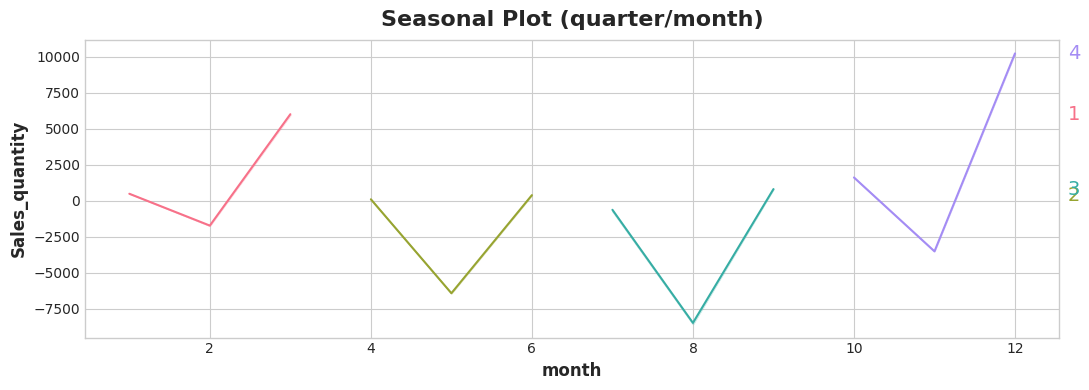

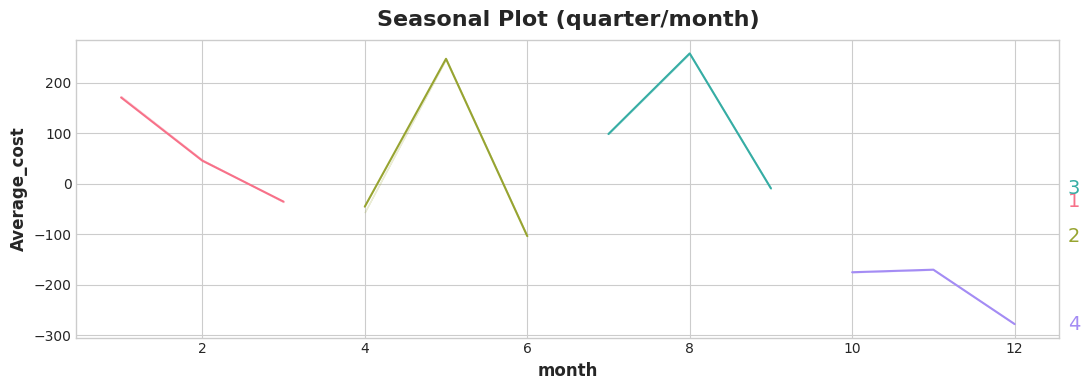

In [10]:
X["quarter"] = X.index.quarter
seasonal_plot(X, y='Revenue', period='quarter', freq='month');
seasonal_plot(X, y='Sales_quantity', period='quarter', freq='month');
seasonal_plot(X, y='Average_cost', period='quarter', freq='month');

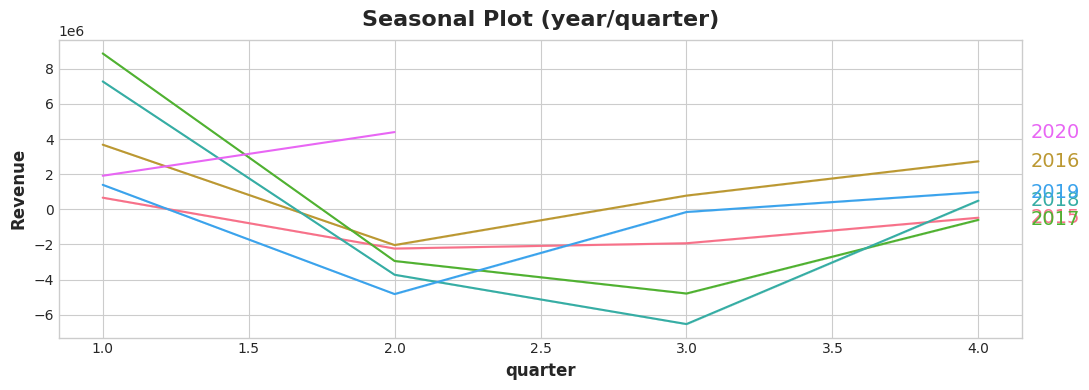

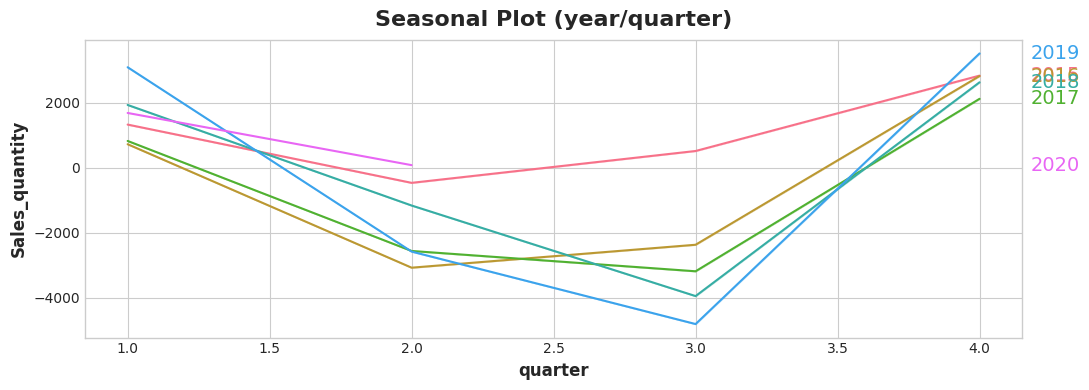

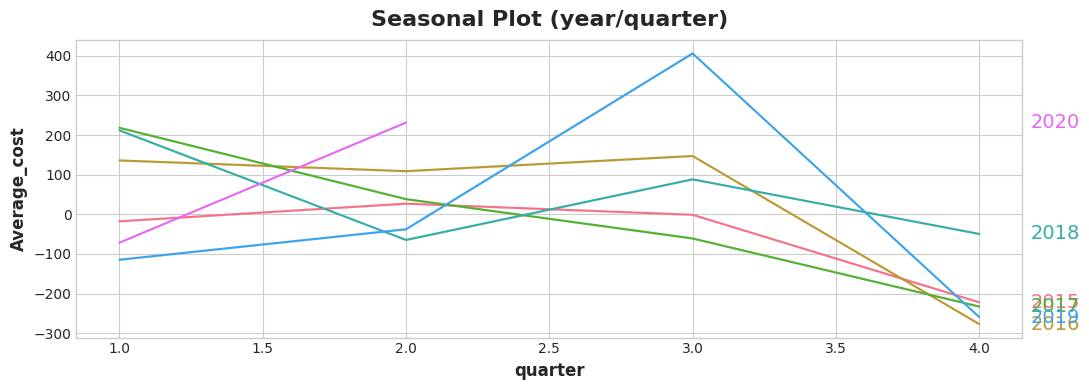

In [11]:
seasonal_plot(X, y='Revenue', period='year', freq='quarter');
seasonal_plot(X, y='Sales_quantity', period='year', freq='quarter');
seasonal_plot(X, y='Average_cost', period='year', freq='quarter');

When all years are overlapped there is visible pattern. Anually and quartaly

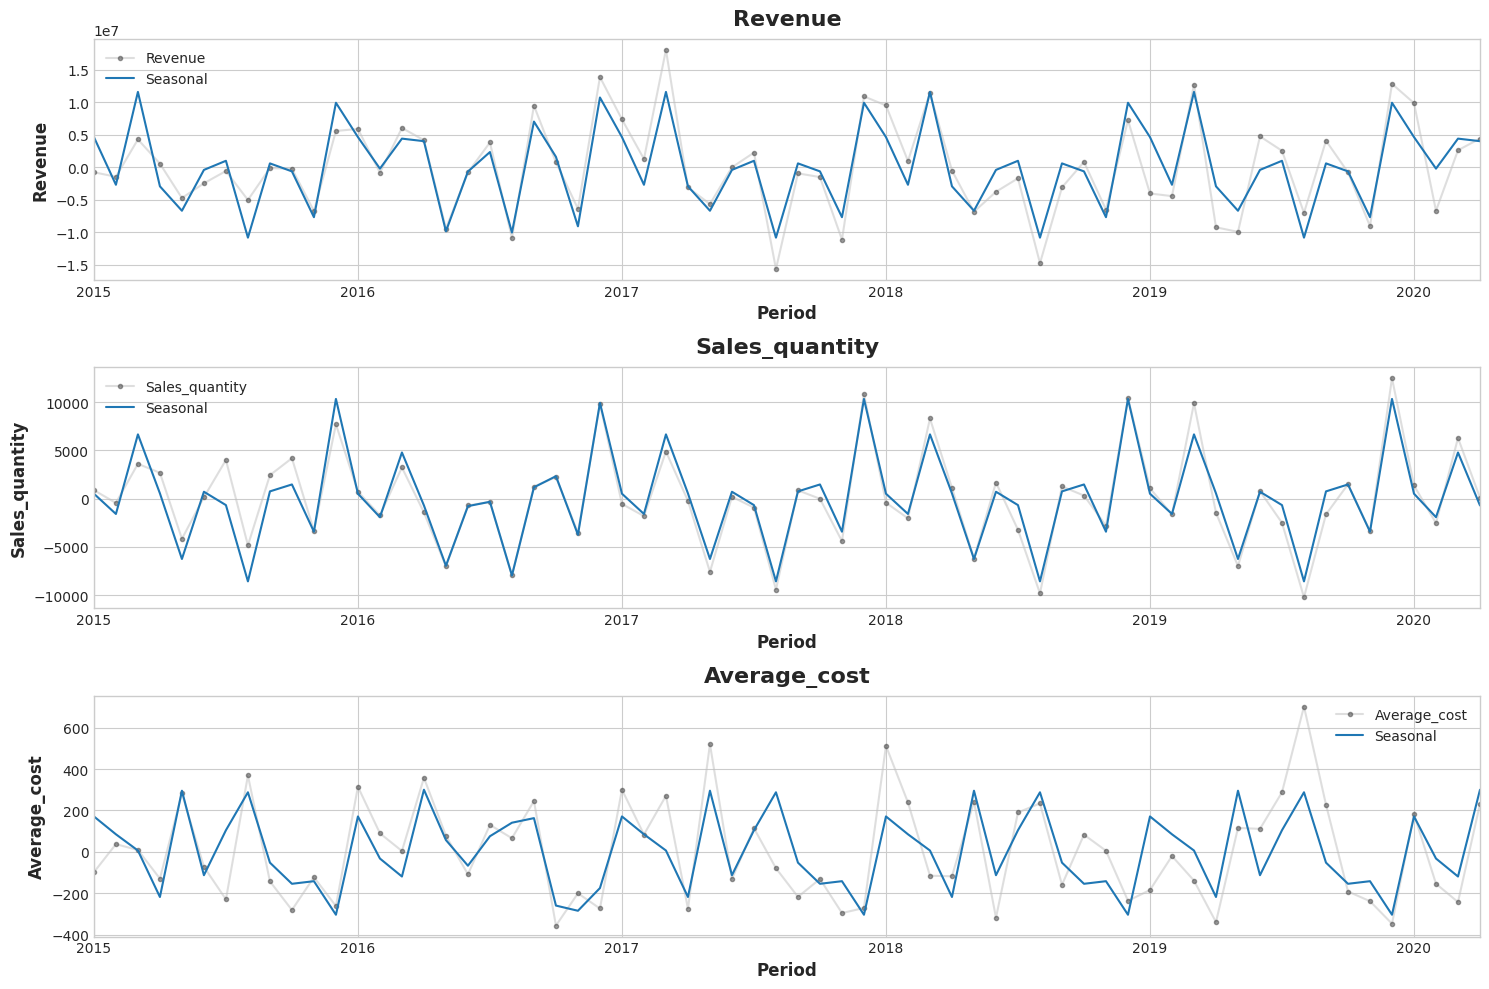

In [12]:
fourier_M = CalendarFourier(freq="M", order=4)
fourier_Y = CalendarFourier(freq="Y", order=4)
dp = DeterministicProcess(
    index=detrended_train.index,
    constant=True,
    order=0,
    seasonal=True,
    additional_terms=[fourier_M, fourier_Y],
    drop=True,
)
X = dp.in_sample()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
axes = axes.flatten()


# There are stored seasons
seasons = []

for i, col in enumerate(detrended_train.columns):
    if i == 3:
        break
    # Average_sales
    if i == 2:
        fourier_Y = CalendarFourier(freq="Y", order=4)
        fourier_Q = CalendarFourier(freq="Q", order=4)
        fourier_M = CalendarFourier(freq="M", order=4)
        dp = DeterministicProcess(
            index=detrended_train.index,
            constant=True,
            order=0,
            seasonal=True,
            additional_terms=[fourier_Y, fourier_Q, fourier_M],
            drop=True,
        )
        X = dp.in_sample()
        
    y = detrended_train[col].copy()
    model = LinearRegression().fit(X, y)
    y_pred = pd.Series(
        model.predict(X),
        index=X.index,
        name='Fitted',
    )
    seasons.append(model.predict(X))
    ax = axes[i] 
    y.plot(ax=ax, **plot_params, alpha=0.5, title=col, ylabel=col)
    y_pred.plot(ax=ax, label="Seasonal")
    ax.legend()

fig.tight_layout()
plt.show()


Both Revenue and Sales_quantity fit quite well, but Average_cost and Payroll have quite big error.

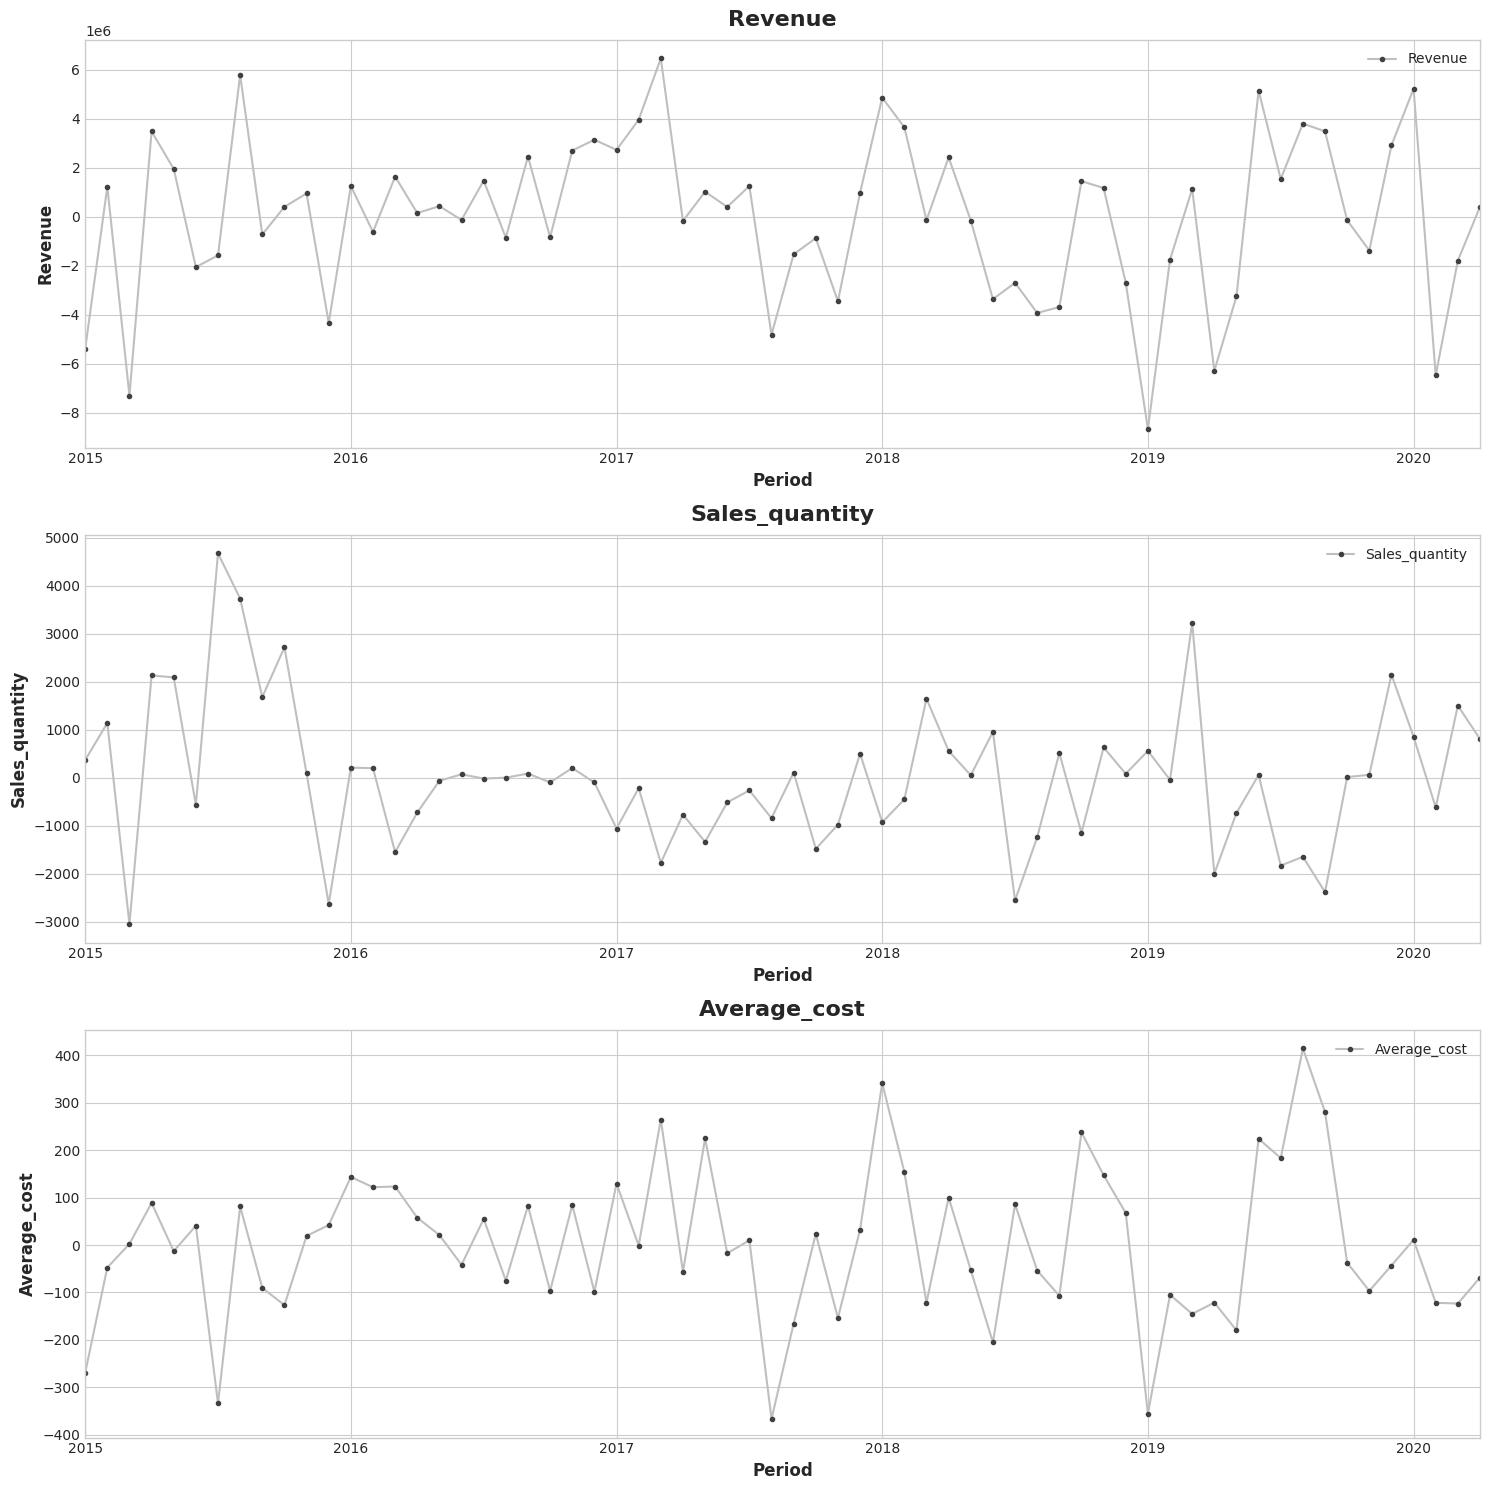

In [13]:
residuals = pd.DataFrame()
residuals["Revenue"] = detrended_train["Revenue"] - seasons[0]
residuals["Sales_quantity"] = detrended_train['Sales_quantity'] - seasons[1]
residuals["Average_cost"] = detrended_train['Average_cost'] - seasons[2]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(residuals.columns):
    ax = axes[i] 
    residuals[col].plot(ax=ax, **plot_params, alpha=1, title=col, ylabel=col)
    ax.legend()

fig.tight_layout()
plt.show()

<Axes: xlabel='Revenue', ylabel='Count'>

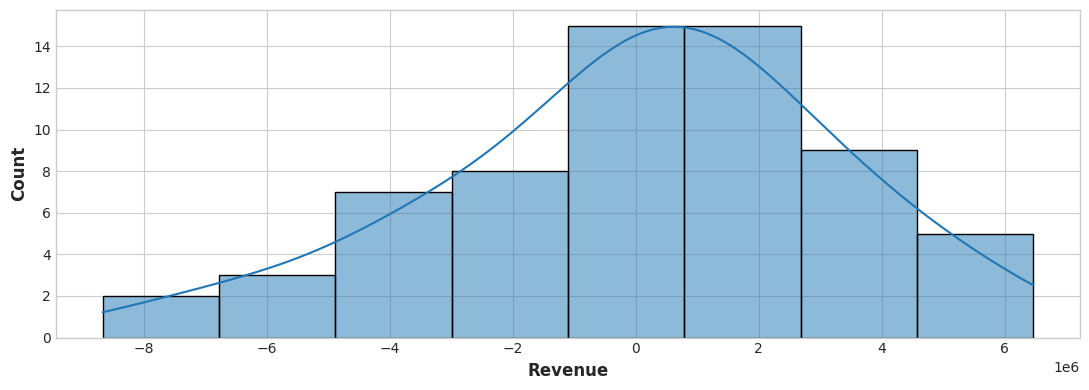

In [14]:
sns.histplot(residuals["Revenue"], kde=True)

<Axes: xlabel='Sales_quantity', ylabel='Count'>

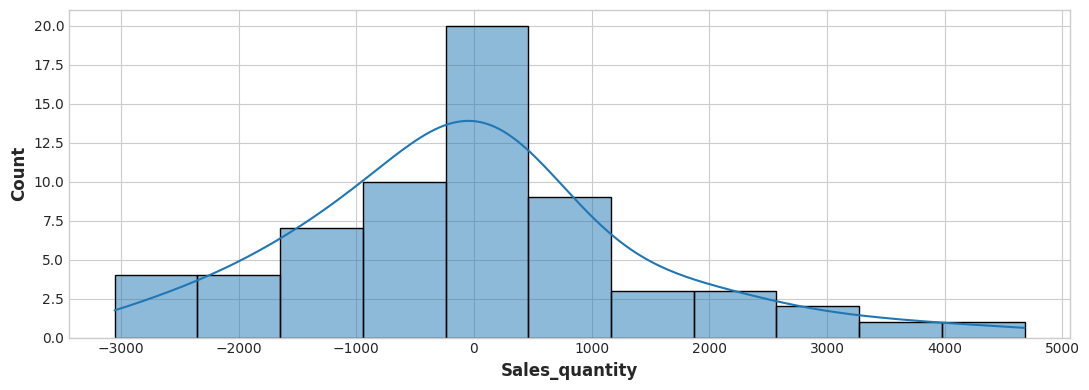

In [15]:
sns.histplot(residuals["Sales_quantity"], kde=True)

<Axes: xlabel='Average_cost', ylabel='Count'>

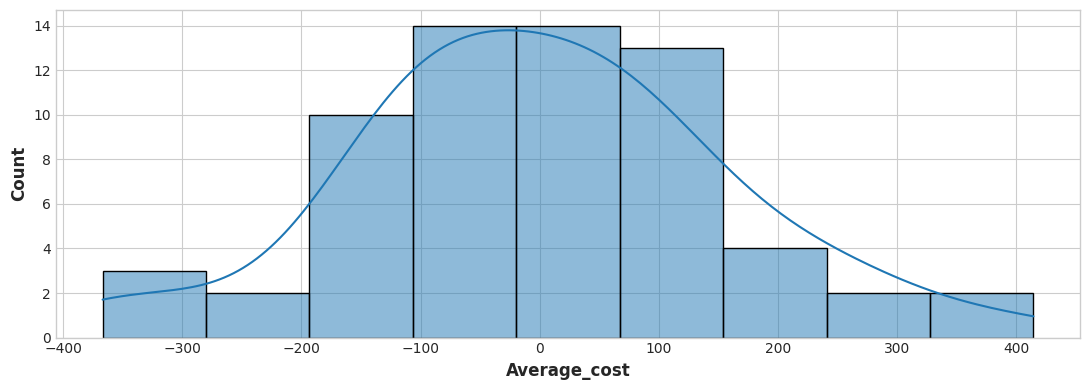

In [16]:
sns.histplot(residuals["Average_cost"], kde=True)

ADF Statistic: -7.027641493501455
p-value: 6.303874769236736e-10
ADF Statistic: -3.3235724457437645
p-value: 0.01385710941243007
ADF Statistic: -3.8973724383926904
p-value: 0.00205426983636017


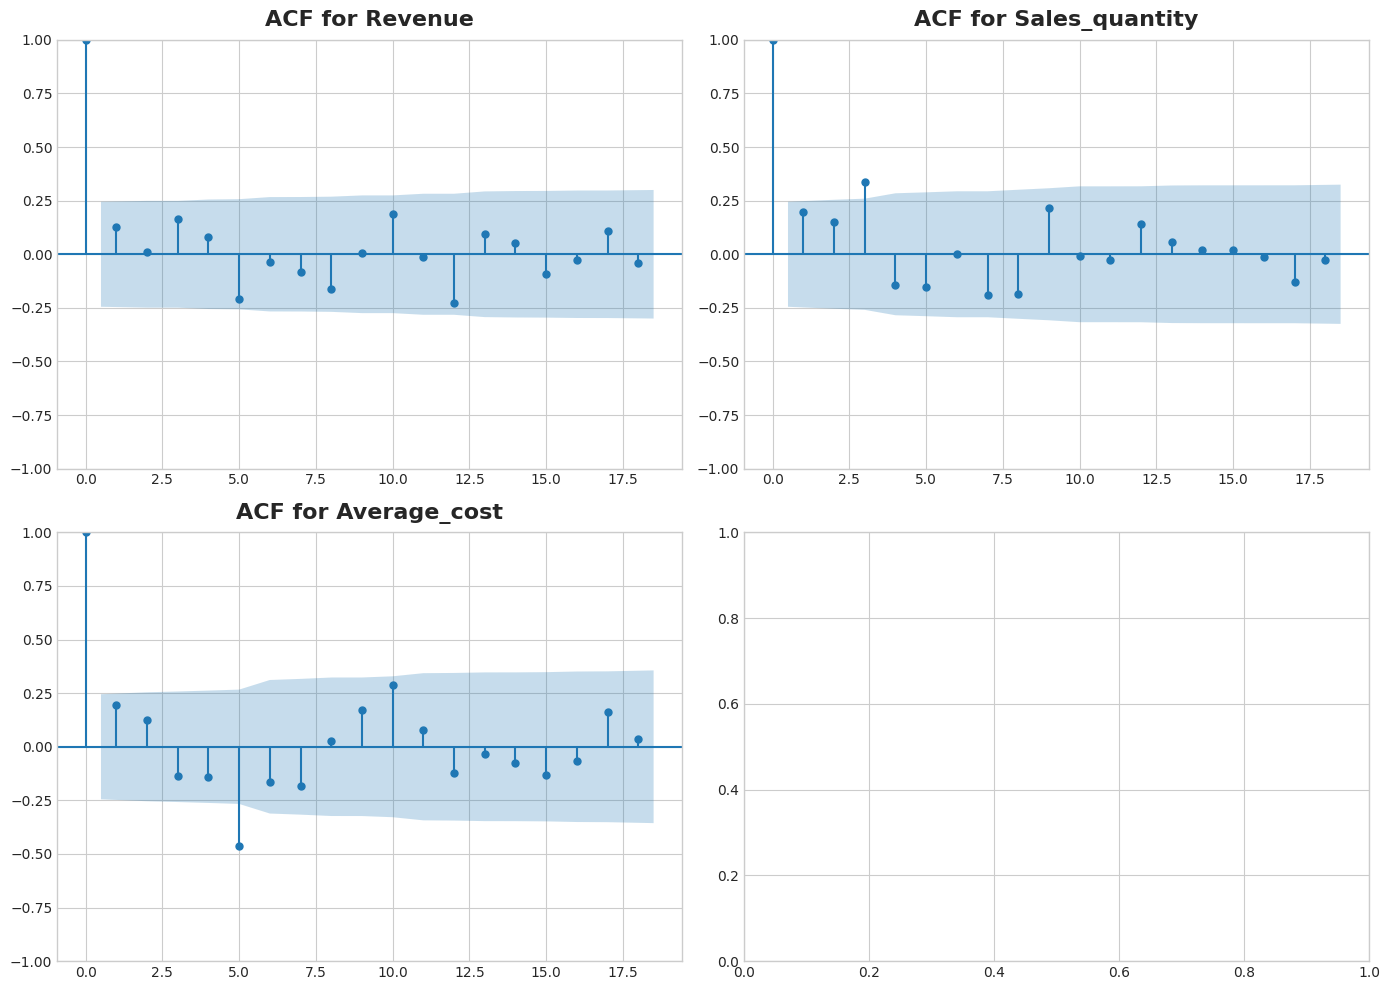

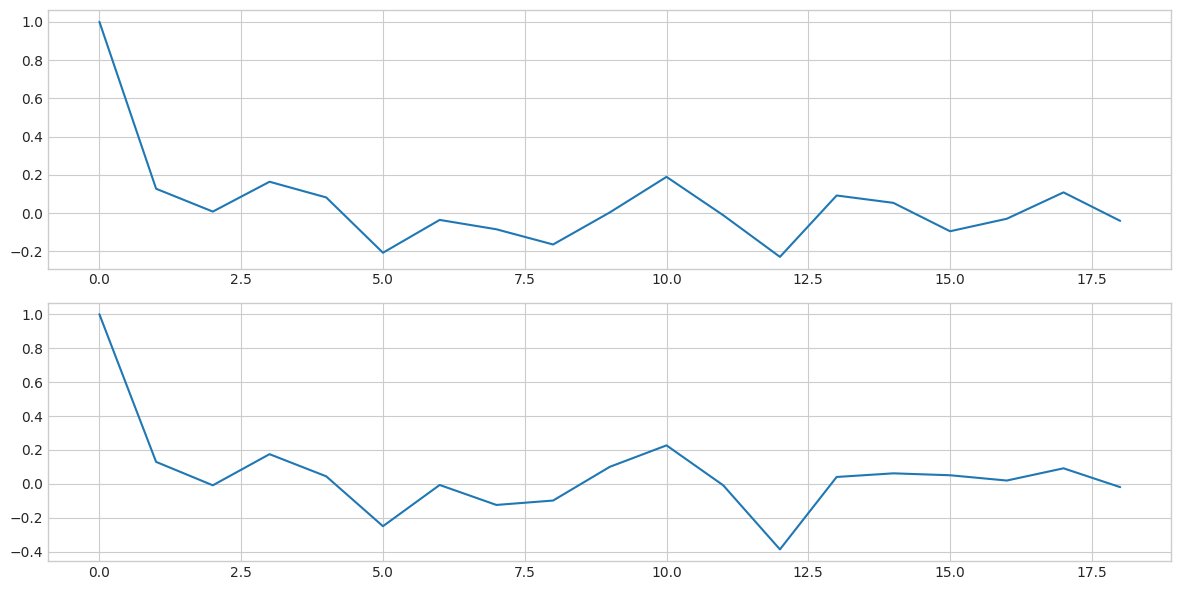

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for col in residuals.columns:
    result = adfuller(residuals[col])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

for i, column in enumerate(residuals.columns):
    plot_acf(residuals[column], lags=18, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(f'ACF for {column}')

plt.tight_layout()
plt.show()


# ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(acf(residuals['Revenue'], nlags=18))
#plt.title('Autocorrelation Function')
plt.subplot(212)
plt.plot(pacf(residuals['Revenue'], nlags=18))
#plt.title('Partial Autocorrelation Function')
plt.show()

Stationary residuals

<Axes: xlabel='Period'>

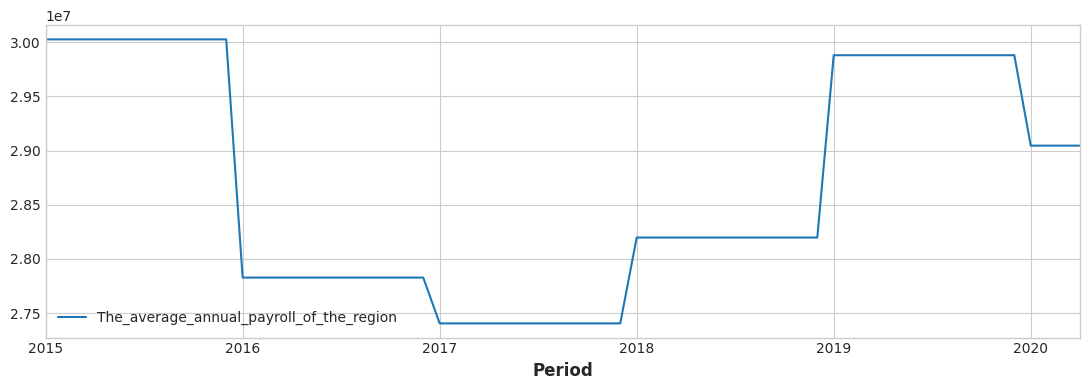

In [18]:
payroll.plot()

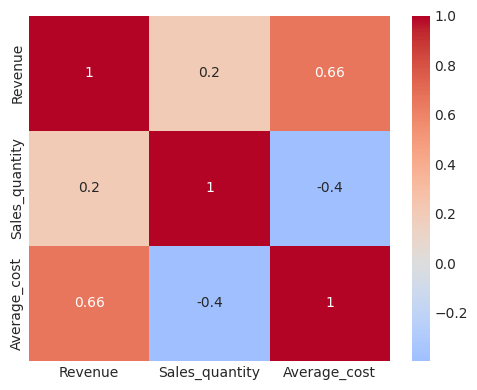

,Revenue,Sales_quantity,Average_cost
Revenue,1.000000,0.195838,0.661975
Sales_quantity,0.195838,1.000000,-0.395089
Average_cost,0.661975,-0.395089,1.000000


In [19]:
correlation_matrix = residuals.corr()
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
#plt.title('Correlation Matrix Heatmap')
plt.show()
correlation_matrix

Residuals are correlated

In [20]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(residuals)

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length - 1])
    return np.array(sequences), np.array(targets)

# THIS MIGHT BE STUPID, I WILL CHECK THT LATER FOR SURE
seq_length = 1
X, y = create_sequences(scaled_data, seq_length)

train_size = int(len(X) * 0.8)
val_size = int(train_size * 0.25)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train, X_val = X_train[:-val_size], X_train[-val_size:]
y_train, y_val = y_train[:-val_size], y_train[-val_size:]

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(X_train.shape[2]))  # Ilość neuronów w wyjściowej warstwie Dense powinna odpowiadać liczbie cech

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=55, batch_size=32, validation_data=(X_val, y_val))

predicted = scaler.inverse_transform(model.predict(X_val))
x_predicted = scaler.inverse_transform(model.predict(X_train))
test_predicted = scaler.inverse_transform(model.predict(X_test))

test_pred_no_scale = model.predict(X_test)

Epoch 1/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 420ms/step - loss: 0.8716 - val_loss: 1.0170
Epoch 2/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.9226 - val_loss: 1.0082
Epoch 3/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8716 - val_loss: 0.9989
Epoch 4/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.9082 - val_loss: 0.9889
Epoch 5/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8819 - val_loss: 0.9787
Epoch 6/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8810 - val_loss: 0.9684
Epoch 7/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8639 - val_loss: 0.9580
Epoch 8/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8504 - val_loss: 0.9473
Epoch 9/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8568 - val_loss: 0.9358
Epoch 10/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8012 - val_loss: 0.9239
Epoch 11/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8529 - val_loss: 0.9115
Epoch 12/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7951 - val_loss: 0.8985


Stop training at 55 epochs to prevent overtraining

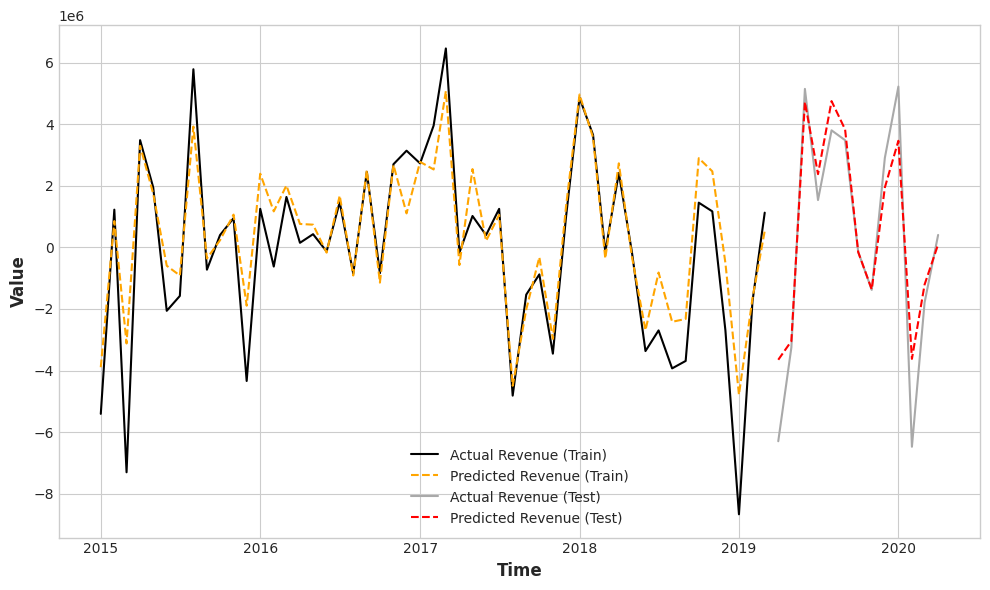

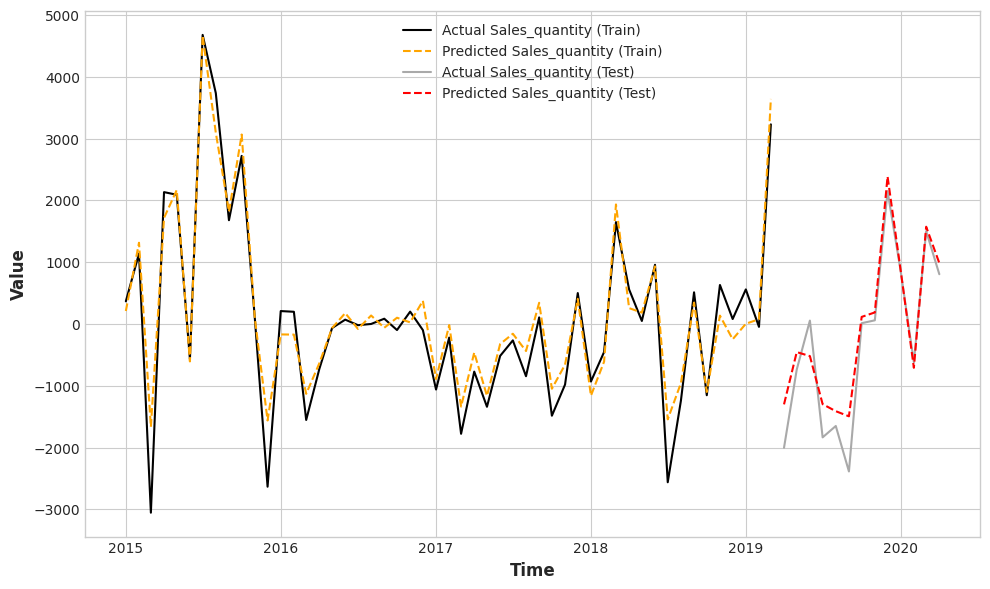

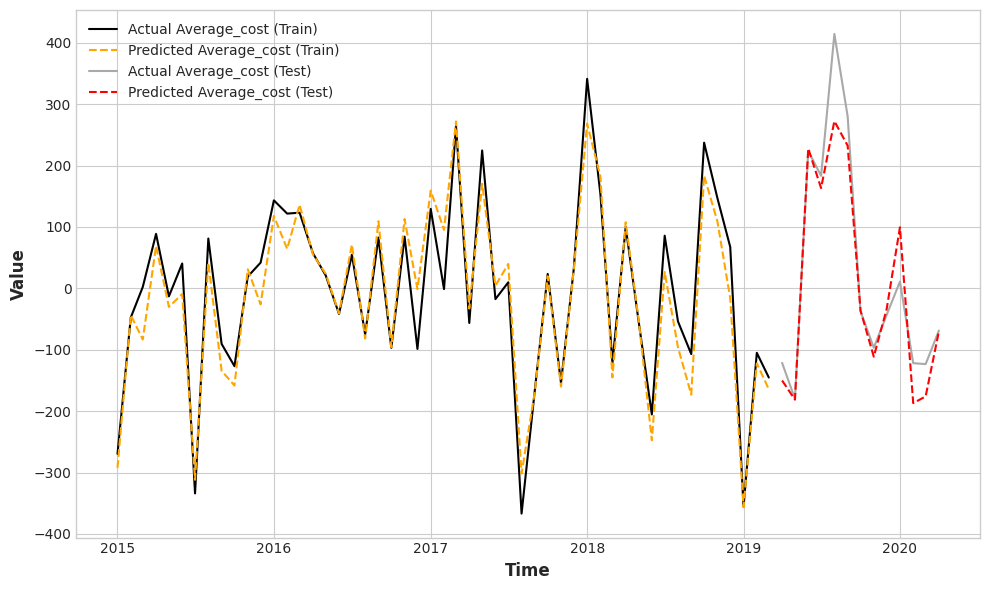

The lowest val_loss at training: 0.13974811136722565
Test MAE (unscalled): 0.2433036210100702


In [21]:
first = residuals.index[:len(y_train)]
second = residuals.index.difference(first)[:len(y_val)]
third = residuals.index.difference(first).difference(second)

y_train_df = pd.DataFrame(scaler.inverse_transform(y_train), index=first)
y_val_df = pd.DataFrame(scaler.inverse_transform(y_val), index=second)
y_test_df = pd.DataFrame(scaler.inverse_transform(y_test), index=third)

y_train_df = pd.concat([y_train_df, y_val_df])

train_pred_df = pd.DataFrame(x_predicted, index=first)
val_pred_df = pd.DataFrame(predicted, index=second)
test_pred_df = pd.DataFrame(test_predicted, index=third)

train_pred_df = pd.concat([train_pred_df, val_pred_df])
first = first.append(second)
col_names = ['Revenue', 'Sales_quantity', 'Average_cost']

for i in range(3):
    plt.figure(figsize=(10, 6))
    plt.plot(first.to_timestamp(), y_train_df[i], label=f'Actual {col_names[i]} (Train)', color="black", linestyle='solid')
    plt.plot(first.to_timestamp(), train_pred_df[i], label=f'Predicted {col_names[i]} (Train)', color="orange", linestyle='dashed')

    plt.plot(third.to_timestamp(), y_test_df[i], label=f'Actual {col_names[i]} (Test)', color="darkgrey", linestyle='solid')
    plt.plot(third.to_timestamp(), test_pred_df[i], label=f'Predicted {col_names[i]} (Test)', color="red", linestyle='dashed')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    #plt.title(f'{col_names[i]} Real vs Predictions')
    plt.tight_layout()
    plt.show()


test_pred_no_scale_df = pd.DataFrame(test_pred_no_scale, index=third)
y_test_no_scale_df = pd.DataFrame(y_test, index=third)
mae_test = mean_absolute_error(y_test_no_scale_df, test_pred_no_scale_df)


print(f"The lowest val_loss at training: {history.history['val_loss'][-1]}")
print(f"Test MAE (unscalled): {mae_test}")

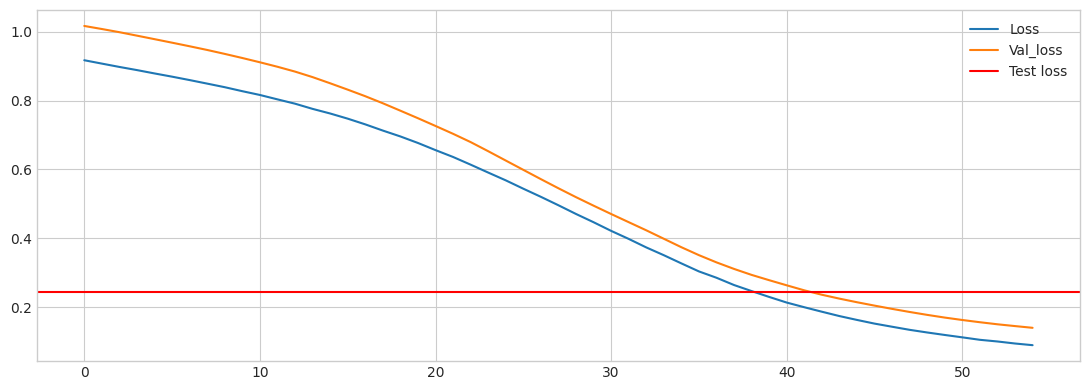

In [22]:
plt.plot(history.history["loss"], label='Loss')
plt.plot(history.history["val_loss"], label='Val_loss')
plt.axhline(y=mae_test, color='r', linestyle='-', label="Test loss")
#plt.title("Loss comparasion")
plt.legend()
fig.tight_layout()
plt.show()

idk why but plt.title() broke